# Cattura DM da parte di una nube molecolare

Considerando una nube molecolare gigante (GMC) sferica con densità uniforme composta esclusivamente da $H_2$ (75%) e $He$ (25%):

- $M_{nube}=10^4 M_{\odot}$

- $R_{nube} = 5 \text{ pc}$

- $T_{nube} = 30 \text{ K}$

e una WIMP con

- $m_{DM}=10 \frac{GeV}{C^2}$

- $\rho_{DM}=0.3 \frac{GeV}{c^2cm^3}$

Mi voglio calcolare quante WIMP cattura nell'unità di tempo sfruttando il fromalismo di Gould1987

## Procedura per la simulazione

- Inizializzo le variabili

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from matplotlib.ticker import LogLocator
from mpl_toolkits.mplot3d import Axes3D

#################### Definizioni variabili  di partenza della simulazione ###########################

#Proprietà nube
X_H2=0.75 #Abbondanza Idrogeno molecolare
X_He=0.25 #Abbondanza He
R_nube0=3 #Raggio nube in parsec
M_nube0=1e4 #massa nube in masse solari
m_ele=[3.3471e-24,6.646e-24]#masse in grammi degli elementi
m_ele=np.array(m_ele)
nomi_ele=["H_2","He"]#nomi degli elementi
abb_ele=[X_H2,X_He]#abbndanze elementi
abb_ele=np.array(abb_ele)

#Prorpietà DM
#rho_DM=0.3 #GeV/(c^2 cm^{-3}
#m_DM=10 #GeV/c^2
#sigma0=1e-35 #sezione d'urto con idrogeno NON molecolare in cm^2

#Velocità della nube rispetto al rest frame della DM
v=220*1e5 #velocità nube in cm/s
v_d=270*1e5 #velocitàd i dispersione in cm/s

#Fattori conversione
mass_GeV_cgs=1.783e-24 #fattore di conversione massa da GeV in cgs
pc_cm=3.086e18 #fattore di conversione pc to cm
M_sun=1.988e33 #Massa solare in g
yr_s=3.154e7 #secondi in un anno

#Costanti
k_b=1.381e-16 #erg/K
G=6.674e-8 #dyne cm^2/g^2
m_p=1.672e-24 #massa protone in g

######################################################################################################
R_nube0=R_nube0*pc_cm#Scrivo il ragio della nube in cm
M_nube0=M_nube0*M_sun#Scrivo la massa della nube in g


- Creo le funzioni per generare gli array di massa,raggio e potenziale gravitazionale 

In [57]:
#Funzioni per generare gli array della fisica della struttura

def calcola_Massa_Raggio(R_max,M_max,mesh):
    '''
    Funzione per calcolarsi l'array della massa (cumulativa) punto per punto e l'array del raggio 
    per una sfera uniformemente densa dato il massimo del raggio e la massima massa.
    '''
    
    rho_media=(M_max)/(4/3*np.pi*np.power(R_max,3))#mi calcolo la densità media della mia sfera
    
    R=np.linspace(1e-1,(R_max),mesh) #array del raggio con un numero di mesh pari alla variabile mesh
    M=[np.trapz(4*np.pi*np.power(R[:i],2)*rho_media,R[:i])for i in range(len(R))]#Array della massa della nube al raggio r
    M=np.array(M)#Lo trasformo in array nupy
    
    return R,M

def calcola_potenziale_gravitazionale(M, R,G):
    '''
    Funzione che calcola l'array del potenziale gravitazionale dati gli array di Massa e Raggio e la costante Gravitazionale
    '''
    
    M_max=np.max(M)
    R_max=np.max(R)
    
    #Mi calcolo l'integrale fino al bordo
    integrale_totale=np.trapz(G*M/(np.power(R,2)),R)
 
    V = [G*(M_max)/(R_max) +(integrale_totale - np.trapz(G * M[:i] / (R[:i]** 2), R[:i])) for i in range(len(R))] # Mi calcolo il potenziale gravitazionale della nube
    #come se fosse una sfera uniformemente carica/densa
    V=np.array(V)
    
    return V

def Chi(a,b):
    chi=np.sqrt(np.pi)/2*\
        (erf(b)-erf(a))
    return chi

def fattore_mediato(G,R,M,V,v_moto,v_disp,M_DM,m_i):
    
    M_max=np.max(M)
    R_max=np.max(R)
    
    phi=V/(G*M_max/R_max)
    mu=M_DM/m_i
    mu_m=(mu-1)/2
    eta_quad=3/2*(v_moto/v_disp)**2
    eta=np.sqrt(eta_quad)
    A_quad=3/2*(2*V/(v_disp**2))*mu/(mu_m**2)
    A_p=np.sqrt(A_quad)+eta
    A_m=np.sqrt(A_quad)-eta
    
    fattore=phi/(2*eta*A_quad)*(\
        (A_p*A_m-1/2)*(Chi(-eta,eta)-Chi(A_m,A_p))\
        +1/2*A_p*np.exp(-np.power(A_m,2))-1/2*A_m*np.exp(-np.power(A_p,2))\
        -eta*np.exp(-eta**2))
    

    f=np.trapz(fattore,M)
    f=np.array(f)/M_max
    if (f<0):
        f=fattore_mediato(G,R,M,V,v_moto,v_disp,M_DM+0.1*M_DM,m_i)
    return f

def C_geom(Rho_DM,M_DM,v_moto,v_disp,R,V):
    R_max=np.max(R)
    v_esc_quad=2*V[-1]
    
    xi=(v_disp**2*np.exp(-3/2*((v_moto/v_disp)**2))+\
        np.sqrt(np.pi/6)*(v_disp/v_moto)*(v_disp**2+3*v_esc_quad+3*v_moto**2)*\
        erf(np.sqrt(3/2)*v_moto/v_disp))/\
        (2*v_disp**2+3*v_esc_quad)
    
    C_geom_val=np.pi*np.power(R_max,2)*\
        (Rho_DM/M_DM)*\
        np.sqrt(8/(3*np.pi))*v_disp*\
        (1+3/2*v_esc_quad/(v_disp**2))*\
        xi
        
    return C_geom_val

def Capture_rate(m_i,X,M_DM,Rho_DM,sigmaH,R,M,V,v_moto,v_disp,ignorante):
    
    M_max=np.max(M)
    
    sigma=sigmaH*np.power((m_i/m_p),4)*((M_DM+m_p)/(M_DM+m_i))**2
    
    
    fat=fattore_mediato(G,R,M,V,v_moto,v_disp,M_DM,m_i)
    
    C=np.sqrt(8/(3*np.pi))*sigma*\
    Rho_DM/M_DM*v_disp*\
    M_max*X/m_i*\
    3*(V[-1]/(v_disp**2))*\
    fat
    
    return C


- Genero gli array della struttura dalle condizioni iniziali

Text(0, 0.5, 'Potenziale gravitazionale [$\\frac{erg}{g}$]')

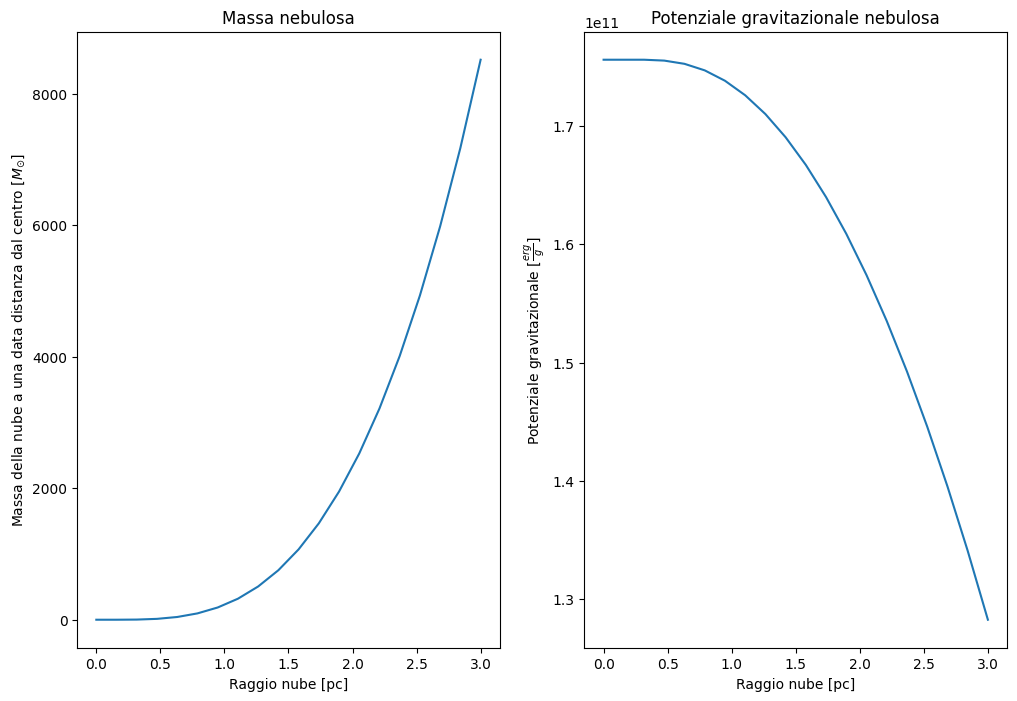

In [58]:
#Mi calcolo l'array dei:
# - Raggio della nube
# - Massa della nube
# - potenziale gravitazionale
####################################################
mesh=20 #mesh in cui suddivido la nube
R_nube,M_nube=calcola_Massa_Raggio(R_nube0,M_nube0,mesh)
V_nube=calcola_potenziale_gravitazionale(M_nube, R_nube,G)
#####################################################

plt.figure(figsize=(12,8))


plt.subplot(121)
plt.title("Massa nebulosa")
plt.plot(R_nube/pc_cm,M_nube/M_sun)
plt.xlabel(r"Raggio nube [pc]")
plt.ylabel(r"Massa della nube a una data distanza dal centro [$M_{\odot}$]")

plt.subplot(122)
plt.title("Potenziale gravitazionale nebulosa")
plt.plot(R_nube/pc_cm,V_nube)
plt.xlabel(r"Raggio nube [pc]")
plt.ylabel(r"Potenziale gravitazionale [$\frac{erg}{g}$]")


- Calcolo dell rate di cattura per ogni singolo ellemento

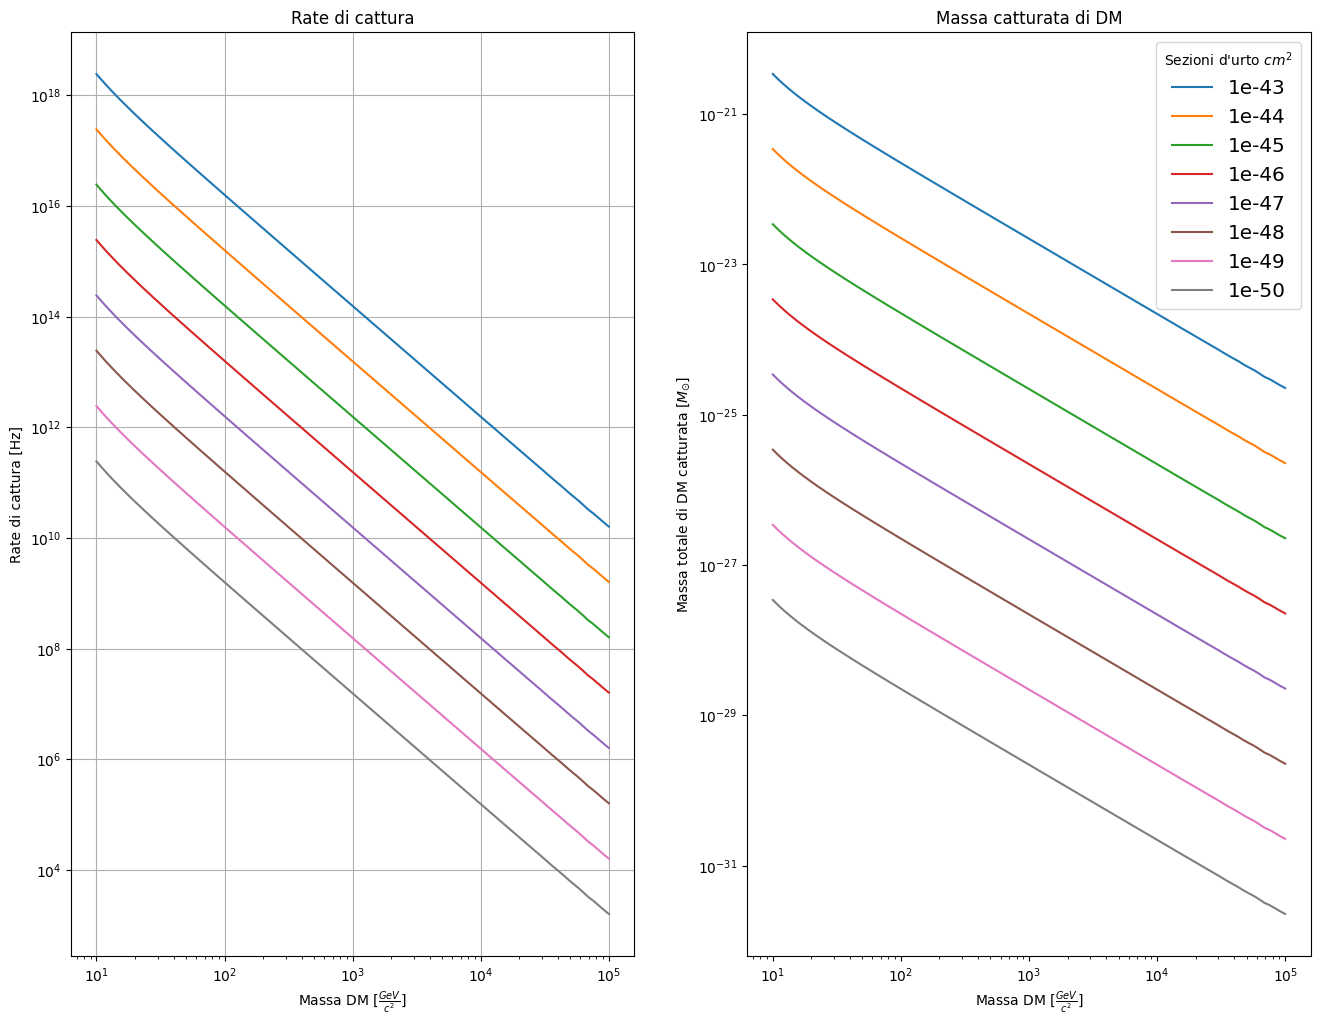

In [63]:
def C_tot(M_ele,Abb_ele,M_DM,Rho_DM,Sigma0,R,M,V,v_mov,v_disp):
    c_ele=[Capture_rate(M_ele[i],Abb_ele[i],M_DM,Rho_DM,Sigma0,R,M,V,v_mov,v_disp,ignorante=0) for i in range(len(M_ele))]
    c_ele=np.array(c_ele)
    c_tot=np.sum(c_ele)
    return c_tot



rho_DM=0.3
rho_DM=rho_DM*mass_GeV_cgs

m_DM=np.logspace(1,5,100)
m_DM_g=m_DM*mass_GeV_cgs
sigma0=np.logspace(-43,-50,8)
c_tot=[C_tot(m_ele,abb_ele,m_DM_g[i],rho_DM,sigma0[0],R_nube,M_nube,V_nube,v,v_d) for i in range(len(m_DM_g))]
c_tot=np.array(c_tot)

tempo=5e9
tempo_s=tempo*yr_s
y_line=[]
plt.figure(figsize=(16, 12))

for j,Sigma0 in enumerate(sigma0):
    c_tot_j=c_tot*Sigma0/sigma0[0]
    plt.subplot(121)
    plt.title("Rate di cattura")
    plt.plot(m_DM,c_tot_j,label=sigma0[j])
    plt.xlabel(r"Massa DM $[\frac{GeV}{c^2}]$")
    plt.ylabel("Rate di cattura [Hz]")
    plt.xscale('log')
    plt.yscale('log')
    
    plt.grid(True)
    
    N_j=c_tot_j*tempo_s
    M_j=N_j*m_DM_g/M_sun
    plt.subplot(122)
    plt.title("Massa catturata di DM")
    plt.plot(m_DM,M_j,label=sigma0[j])
    plt.xlabel(r"Massa DM $[\frac{GeV}{c^2}]$")
    plt.ylabel(r"Massa totale di DM catturata [$M_{\odot}$]")
    plt.xscale('log')
    plt.yscale('log')
    

plt.legend(title=r"Sezioni d'urto $cm^2$",fontsize='x-large')

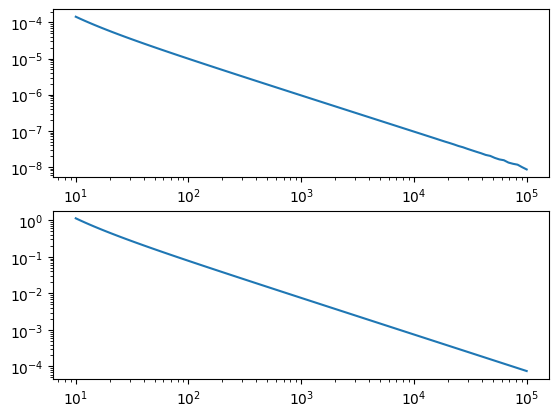

In [60]:
fattori=[fattore_mediato(G,R_nube,M_nube,V_nube,v,v,m_DM_g[i],m_ele[0])for i in range(len(m_DM))]
plt.subplot(211)
plt.plot(m_DM,fattori)
plt.xscale("log")
plt.yscale("log")

plt.subplot(212)
plt.plot(m_DM,(m_DM_g/m_ele[0])/(np.power(m_DM_g/(2*m_ele[0])-1/2,2)))
plt.xscale("log")
plt.yscale("log")

